## Data preprocessing

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import os
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

In [3]:
# Manually setting the NLTK data path to be within the virtual environment
nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')

if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)

# Download the necessary data files to the specified path
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)

[nltk_data] Downloading package stopwords to /Library/Frameworks/Pytho
[nltk_data]     n.framework/Versions/3.11/lib/python3.11/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Library/Frameworks/Python.
[nltk_data]     framework/Versions/3.11/lib/python3.11/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data] Downloading package punkt to /Library/Frameworks/Python.fr
[nltk_data]     amework/Versions/3.11/lib/python3.11/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# load the translated dataset

weibo_data = pd.read_csv('weibo_reddit_dataset/translated_version.csv')

In [5]:
# Initialize the lemmatizer and stopwords

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

weibo_data['tokens_en'] = weibo_data['content_en'].apply(clean_text)
weibo_data['clean_text_en'] = weibo_data['tokens_en'].apply(lambda x: ' '.join(x))

In [6]:
# Convert all comments to string (if they are not already)
weibo_data['clean_text_en'] = weibo_data['clean_text_en'].astype(str)

# Check for empty strings
print((weibo_data['clean_text_en'] == '').sum())

weibo_data = weibo_data[weibo_data['clean_text_en'] != '']

19


In [7]:
# Define a normalization function
def normalize_text(text):
    # Replace synonyms or variations with a standard term
    text = text.replace('israeli', 'israel')
    text = text.replace('palestinian', 'palestine')
    return text

def tokenize(text):

    tokens = word_tokenize(text)
    
    return tokens

# Apply normalization to the 'content' column
weibo_data['normalized_content'] = weibo_data['clean_text_en'].apply(normalize_text)
weibo_data['nom_tokens'] = weibo_data['normalized_content'].apply(tokenize)

In [8]:
# Filter Data Based on Specific Topics
import json

with open('specific_topics.json', 'r', encoding='utf-8') as f:
    loaded_specific_topics = json.load(f)


# Filter the DataFrame to include only rows where the specific topic is mentioned
topic_filtered_df = weibo_data[weibo_data['topic'].apply(lambda topic_list: any(topic in topic_list for topic in loaded_specific_topics))]

# Word Frequency

In [9]:
from collections import Counter
# Flatten the list of tokens into a single list
all_tokens = [token for sublist in topic_filtered_df['tokens_en'] for token in sublist]

# Calculate word frequencies using Counter
word_freq = Counter(all_tokens)

# Calculate the total number of tokens
total_tokens = sum(word_freq.values())

# Convert the word frequency dictionary into a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

# Calculate the relative frequency and add it to the DataFrame
word_freq_df['relative_frequency'] = word_freq_df['frequency'] / total_tokens

# Sort by frequency (optional)
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Export to CSV
word_freq_df.to_csv('results/en_weibo_word_frequency_0.csv', index=False)

# Display the top 10 words with their frequencies and relative frequencies (optional)
print(word_freq_df.head(10))

           word  frequency  relative_frequency
3      conflict       9862            0.028777
23       israel       7213            0.021047
26      israeli       6593            0.019238
7   palestinian       6343            0.018508
87         gaza       3938            0.011491
61        video       3566            0.010405
0     palestine       3299            0.009626
34        hamas       3053            0.008908
27        death       2844            0.008299
60        weibo       2782            0.008118


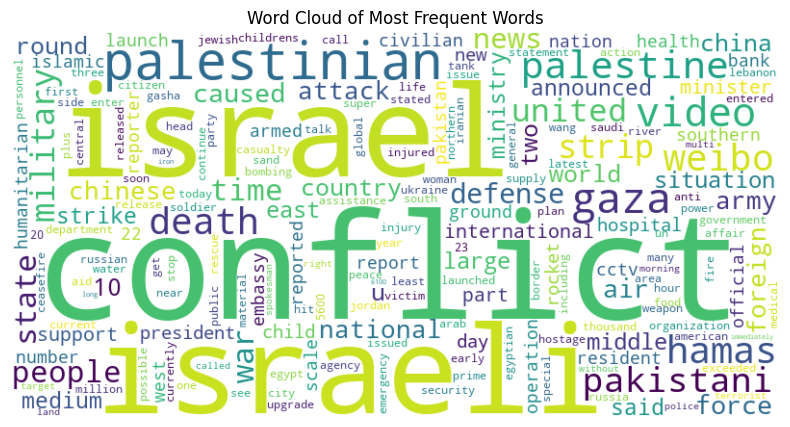

In [11]:
# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  
    max_words=200
).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Most Frequent Words')
plt.show()


# Sentiment analysis

In [12]:
# Download VADER lexicon (only needed the first time)
#nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# analyze sentiment using VADER
def analyze_sentiment_vader(text):
    # Analyze sentiment and return the compound score
    return sia.polarity_scores(text)['compound']

# Apply the VADER sentiment analysis to the 'clean_text_en' column
topic_filtered_df['sentiment_score'] = topic_filtered_df['clean_text_en'].apply(analyze_sentiment_vader)

# Function to categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment categorization to the sentiment scores
topic_filtered_df['sentiment'] = topic_filtered_df['sentiment_score'].apply(categorize_sentiment)


/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_71708/2520403513.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_filtered_df['sentiment_score'] = topic_filtered_df['clean_text_en'].apply(analyze_sentiment_vader)
/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_71708/2520403513.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_filtered_df['sentiment'] = topic_filtered_df['sentiment_score'].apply(categorize_sentiment)


In [13]:
# Group by sentiment category
grouped_df = topic_filtered_df.groupby('sentiment')

sentiment_counts = grouped_df.size()
print(sentiment_counts)

grouped_df_as_df = grouped_df.size().reset_index(name='counts')

# Save the result as a CSV file
grouped_df_as_df.to_csv('results/weibo_en_sentiment_statistics.csv', index=False)

sentiment
Negative    6936
Neutral      349
Positive    2298
dtype: int64


In [14]:
# calculate mean and median
sentiment_stats_mean = topic_filtered_df['sentiment_score'].mean()
sentiment_stats_median = topic_filtered_df['sentiment_score'].median()
print(sentiment_stats_mean,sentiment_stats_median)

-0.35822271731190647 -0.5574


## Topic Modelling

In [16]:
# choose which token to use

#dictionary = corpora.Dictionary(topic_filtered_df['tokens_en'])
#corpus = [dictionary.doc2bow(text) for text in topic_filtered_df['tokens_en']]

dictionary = corpora.Dictionary(topic_filtered_df['nom_tokens'])
corpus = [dictionary.doc2bow(text) for text in topic_filtered_df['nom_tokens']]

In [36]:
def compute_coherence_perplexity_values(corpus, dictionary, start, limit, step):
    coherence_values = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(lda_model)
        
        # Calculate Coherence
        coherence_model_lda = CoherenceModel(model=lda_model, texts=topic_filtered_df['nom_tokens'], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

        # Calculate Perplexity
        log_perplexity = lda_model.log_perplexity(corpus)
        perplexity = np.exp(-log_perplexity)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

# Set the range for the number of topics
start, limit, step = 2, 11, 1
model_list, coherence_values, perplexity_values = compute_coherence_perplexity_values(corpus, dictionary, start, limit, step)

# Print Coherence and Perplexity
for num_topics, coherence, perplexity in zip(range(start, limit, step), coherence_values, perplexity_values):
    print(f'Number of Topics: {num_topics}, Coherence Value: {coherence}, Perplexity: {perplexity}')

# Locate the optimal choice
optimal_idx = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_idx]
optimal_num_topics = range(start, limit, step)[optimal_idx]

print(f'Optimal Number of Topics: {optimal_num_topics}')
print(f'Perplexity at Optimal Number of Topics: {perplexity_values[optimal_idx]}')


Number of Topics: 2, Coherence Value: 0.4592450183290281, Perplexity: 1660.0625058251255
Number of Topics: 3, Coherence Value: 0.4705918381793992, Perplexity: 1573.267639910148
Number of Topics: 4, Coherence Value: 0.496768912969265, Perplexity: 1533.4063196897062
Number of Topics: 5, Coherence Value: 0.47549961351224346, Perplexity: 1454.1471641250305
Number of Topics: 6, Coherence Value: 0.4889765273303602, Perplexity: 1524.7190149990504
Number of Topics: 7, Coherence Value: 0.48307357908634296, Perplexity: 1460.2571310013354
Number of Topics: 8, Coherence Value: 0.49465656247283535, Perplexity: 1594.7352168483408
Number of Topics: 9, Coherence Value: 0.5003959836457833, Perplexity: 1687.4353695447842
Number of Topics: 10, Coherence Value: 0.5019105326225554, Perplexity: 1901.8280115452192
Optimal Number of Topics: 10
Optimal Coherence Value: 0.5019105326225554
Perplexity at Optimal Number of Topics: 1901.8280115452192


In [71]:
dictionary = corpora.Dictionary(topic_filtered_df['nom_tokens'])
corpus = [dictionary.doc2bow(text) for text in topic_filtered_df['nom_tokens']]

# create and train LDA model
num_topics = 9
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)


for idx, topic in lda_model.print_topics(num_words=10):
    print(f'Topic: {idx + 1} : {topic}\n')

Topic: 1 : 0.031*"china" + 0.031*"chinese" + 0.029*"foreign" + 0.017*"israel" + 0.014*"ministry" + 0.012*"situation" + 0.012*"conflict" + 0.012*"country" + 0.012*"citizen" + 0.011*"embassy"

Topic: 2 : 0.024*"nation" + 0.022*"united" + 0.014*"un" + 0.014*"egypt" + 0.014*"humanitarian" + 0.012*"wang" + 0.010*"general" + 0.007*"council" + 0.007*"material" + 0.006*"resolution"

Topic: 3 : 0.035*"conflict" + 0.028*"pakistani" + 0.025*"video" + 0.024*"weibo" + 0.014*"le" + 0.010*"dome" + 0.009*"israel" + 0.009*"system" + 0.009*"iron" + 0.009*"chinese"

Topic: 4 : 0.086*"palestine" + 0.078*"conflict" + 0.051*"video" + 0.040*"weibo" + 0.039*"israel" + 0.029*"pakistani" + 0.024*"gaza" + 0.017*"child" + 0.017*"world" + 0.011*"reporter"

Topic: 5 : 0.112*"death" + 0.079*"palestine" + 0.061*"conflict" + 0.042*"west" + 0.040*"health" + 0.038*"jordan" + 0.037*"bank" + 0.034*"round" + 0.034*"river" + 0.026*"plus"

Topic: 6 : 0.032*"east" + 0.032*"middle" + 0.030*"conflict" + 0.025*"israel" + 0.024*"

In [ ]:
# Initialize an array to hold the topic proportions
topic_proportions = np.zeros(num_topics)

# Initialize a counter array to count documents with each topic as dominant
topic_document_counts = np.zeros(num_topics)

# Calculate the topic distribution across all documents
for bow in corpus:
    doc_topics = lda_model.get_document_topics(bow, minimum_probability=0)
    # Determine the dominant topic for the current document
    dominant_topic_index = max(doc_topics, key=lambda x: x[1])[0]
    
    # Increment the count for the dominant topic
    topic_document_counts[dominant_topic_index] += 1
    
    # Update topic proportions
    for topic_num, prop in doc_topics:
        topic_proportions[topic_num] += prop

# Normalize the proportions
topic_proportions /= len(corpus)

# Create a DataFrame to display the topics and their proportions and counts
data = {
    "Topic #": [f"Topic #{i + 1}" for i in range(num_topics)],
    "Proportion": topic_proportions,
    "Document Count": topic_document_counts,
    "Top Words": [", ".join(words) for words in top_words_per_topic]
}

df_t = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df_t.to_csv('results/en_weibo_lda_topics.csv', index=False)

# Display the table
print(df_t)


In [73]:
# get the index for specific words
def get_word_index(word):
    return dictionary.token2id.get(word)

israel_word_index = get_word_index('israel')
palestine_word_index = get_word_index('palestine')

if israel_word_index is not None:
    topic_term_distribution = lda_model.get_topics()
    israel_topic_index = topic_term_distribution[:, israel_word_index].argmax()
    print(f"'Israel'  Topic #{israel_topic_index + 1}")

if palestine_word_index is not None:
    topic_term_distribution = lda_model.get_topics()
    palestine_topic_index = topic_term_distribution[:, palestine_word_index].argmax()
    print(f"'Palestine' Topic #{palestine_topic_index + 1}")

'Israel'  Topic #7
'Palestine' Topic #4


In [74]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Function to get the topic distribution for each row
def get_topic_distribution(row):
    #bow = dictionary.doc2bow(row['tokens_en'])  
    bow = dictionary.doc2bow(row['nom_tokens'])  
    return lda_model.get_document_topics(bow, minimum_probability=0)

# Apply the function to calculate topic distribution for each document
topic_filtered_df['topic_distribution'] = topic_filtered_df.apply(get_topic_distribution, axis=1)


# Function to determine geopolitical stance based on sentiment score and topic distribution
def determine_geopolitical_stance(row):
    sentiment_score = row['sentiment_score']
    topic_distribution = row['topic_distribution']  # Use the pre-computed topic distribution
    
    
    # Ensure that topic_distribution is a list of tuples
    if not isinstance(topic_distribution, list) or len(topic_distribution) == 0:
        return 'Neutral/Stance Not Clear'
    
    # Find the most relevant topic index (highest probability)
    dominant_topic_index = max(topic_distribution, key=lambda x: x[1])[0]  # x[1] is the probability, x[0] is the topic index
    
    # Determine stance based on sentiment score and dominant topic
    if sentiment_score <= -0.05 and dominant_topic_index == israel_topic_index:
        return 'Against Israel'
    elif sentiment_score <= -0.05 and dominant_topic_index == palestine_topic_index:
        return 'Against Palestine'
    elif sentiment_score >= 0.05 and dominant_topic_index == israel_topic_index:
        return 'Supports Israel'
    elif sentiment_score >= 0.05 and dominant_topic_index == palestine_topic_index:
        return 'Supports Palestine'
    else:
        return 'Neutral/Stance Not Clear'

# Apply the function to determine geopolitical stances for each document
topic_filtered_df['geopolitical_stance'] = topic_filtered_df.apply(determine_geopolitical_stance, axis=1)


/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_54252/846819969.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_filtered_df['topic_distribution'] = topic_filtered_df.apply(get_topic_distribution, axis=1)
/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_54252/846819969.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_filtered_df['geopolitical_stance'] = topic_filtered_df.apply(determine_geopolitical_stance, axis=1)


In [75]:
# Group the DataFrame by 'geopolitical_stance'
grouped_df = topic_filtered_df.groupby('geopolitical_stance')
# Count the number of entries for each geopolitical stance
count_per_stance = grouped_df.size()
print(count_per_stance)

geopolitical_stance
Against Israel              1843
Against Palestine           1527
Neutral/Stance Not Clear    5454
Supports Israel              297
Supports Palestine           462
dtype: int64


In [87]:
# try more words here

import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Function to get the topic index for a specific word
def get_word_topic_index(word, lda_model, dictionary):
    word_index = dictionary.token2id.get(word)
    if word_index is not None:
        topic_term_distribution = lda_model.get_topics()
        # Find the topic with the highest probability for this word
        return topic_term_distribution[:, word_index].argmax()
    return None

# Function to extract sentiment scores for documents belonging to a particular topic
def get_sentiment_scores_by_topic(df, topic_index):
    # Filter documents where the given topic has the highest probability
    topic_docs = df[df['dominant_topic'] == topic_index]
    return topic_docs['sentiment_score']

# Function to determine the dominant topic for each document
def determine_dominant_topic(row):
    topic_distribution = row['topic_distribution']
    if not topic_distribution:
        return None
    # Find the most relevant topic index (highest probability)
    return max(topic_distribution, key=lambda x: x[1])[0]  # x[1] is the probability, x[0] is the topic index

# Apply the function to determine dominant topics for each document
topic_filtered_df['dominant_topic'] = topic_filtered_df.apply(determine_dominant_topic, axis=1)

# Get topic indices for specific words : feel free to try here
word_to_examine = 'palestine'
topic_index_1 = get_word_topic_index(word_to_examine, lda_model, dictionary)

# Compute sentiment scores for documents related to specific topics
if topic_index_1 is not None:
    israel_docs = topic_filtered_df[topic_filtered_df['dominant_topic'] == topic_index_1]
    israel_sentiment_scores = get_sentiment_scores_by_topic(israel_docs, topic_index_1)
    print(f"Sentiment scores for documents related to the word '{word_to_examine}' (Topic #{topic_index_1 + 1}):")
    print(israel_sentiment_scores.describe())  # Summary statistics



Sentiment scores for documents related to the word 'palestine' (Topic #4):
count    2069.000000
mean       -0.327642
std         0.493067
min        -0.988000
25%        -0.750600
50%        -0.361200
75%         0.000000
max         0.973500
Name: sentiment_score, dtype: float64


/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_54252/3907949920.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_filtered_df['dominant_topic'] = topic_filtered_df.apply(determine_dominant_topic, axis=1)
